In [123]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
import sklearn as sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [83]:
data_simple = pd.read_csv('data_simple.csv', encoding = "ISO-8859-1", low_memory=False, index_col=0)

# CLEAN DATA

In [84]:
#SHOULD WE BE USING ADD_DATE instead of ARREST_DATE? need to check # of missing values for ADD_DATE
rearrest = data_simple[['BOFI_NBR','ARREST_DATE']].copy()

In [85]:
rearrest.count()

BOFI_NBR       280293
ARREST_DATE    150979
dtype: int64

In [86]:
#Drop rows with missing values
rearrest.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print('%s rows' %(rearrest.shape[0]))

150979 rows


In [87]:
#Drop if arrest date is before 1988
rearrest = rearrest[rearrest['ARREST_DATE']>=19880101]

In [88]:
#Drop if BOFI_NBR =/ or 00000
rearrest = rearrest[rearrest['BOFI_NBR']!='/']
rearrest = rearrest[rearrest['BOFI_NBR']!='00000']

In [89]:
rearrest.count()

BOFI_NBR       147834
ARREST_DATE    147834
dtype: int64

In [90]:
#drop duplicates 
rearrest=rearrest.drop_duplicates()

In [91]:
rearrest.count()

BOFI_NBR       129845
ARREST_DATE    129845
dtype: int64

In [92]:
#add column with # of arrests for each BOFI_NBR
rearrest['ARREST_CNT'] = rearrest.groupby('BOFI_NBR')['ARREST_DATE'].transform('count')

In [93]:
#FIRST_ARREST = 0 as flag for first arrest, FIRST_ARREST = 1 means it's the second arrest for this arrestee, etc.
rearrest.sort_values(by = ['BOFI_NBR','ARREST_DATE'], inplace=True)
rearrest['FIRST_ARREST'] = rearrest.groupby('BOFI_NBR').cumcount()

In [94]:
#add flag for whether BOFI_NBR has rearrest
#using & for elementwise operation
rearrest['REARREST_FLAG'] = np.where((rearrest['ARREST_CNT']>1) & \
                                 (rearrest['ARREST_CNT']-1 != rearrest['FIRST_ARREST']),1,0)

### Calculating Average Time to Rearrest

#### Average Time to First Rearrest

In [95]:
first_arrests = rearrest.loc[(rearrest['REARREST_FLAG']==1) & (rearrest['FIRST_ARREST'] == 0)]

second_arrests = rearrest.loc[(rearrest['FIRST_ARREST'] == 1)]

arrests_1_2 = pd.merge(first_arrests, second_arrests, \
		on=['BOFI_NBR'], how='left')

In [96]:
def to_date(col):
    '''Given a pandas series, returns pandas dates for non-missing valid dates'''
    col.dropna(inplace=True)
    col = col[col!=0]
    col = col.astype(int)
    converted = pd.to_datetime(col, errors='coerce', format='%Y%m%d')
    return converted

In [97]:
arrests_1_2['ARREST_DATE_1'] = to_date(arrests_1_2['ARREST_DATE_x'])

arrests_1_2['ARREST_DATE_2'] = to_date(arrests_1_2['ARREST_DATE_y'])

arrests_1_2['DIFFERENCE'] = arrests_1_2['ARREST_DATE_2'] - arrests_1_2['ARREST_DATE_1']

In [98]:
arrests_1_2['DIFFERENCE'].mean() #660 days

Timedelta('660 days 00:51:45.348237')

In [99]:
arrests_1_2['DIFFERENCE'].median()

Timedelta('389 days 00:00:00')

#### Average time to next arrest

In [ ]:
next_arrest = rearrest.loc[(rearrest['FIRST_ARREST'] > 0)]

next_arrest['FIRST_ARREST'] = next_arrest['FIRST_ARREST'] - 1 #subtract 1 from the cumulative count

arrest_pairs = pd.merge(rearrest, next_arrest,\
                       on=['BOFI_NBR', 'FIRST_ARREST'], how = 'inner')

arrest_pairs['ARREST_DATE_x'] = to_date(arrest_pairs['ARREST_DATE_x'])

arrest_pairs['ARREST_DATE_y'] = to_date(arrest_pairs['ARREST_DATE_y'])

arrest_pairs['TIME_BETWEEN_ARRESTS'] = arrest_pairs['ARREST_DATE_y'] - arrest_pairs['ARREST_DATE_x']

In [121]:
arrest_pairs['TIME_BETWEEN_ARRESTS'].mean()

Timedelta('550 days 03:54:20.721935')

In [120]:
arrest_pairs['TIME_BETWEEN_ARRESTS'].median()

Timedelta('291 days 00:00:00')

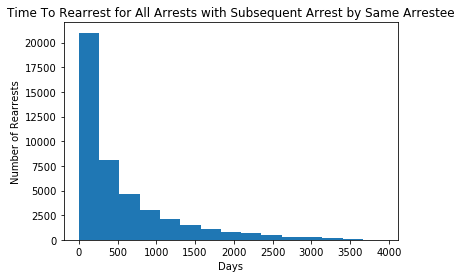

In [136]:
plt.hist((arrest_pairs['TIME_BETWEEN_ARRESTS'] / np.timedelta64(1, 'D')).astype(int), bins=15)
plt.title('Time To Rearrest for All Arrests with Subsequent Arrest by Same Arrestee')
plt.ylabel('Number of Rearrests')
plt.xlabel('Days')
plt.savefig('time_to_rearrest.png')

## CREATE TRAINING DATA

In [13]:
rearrest[:20]

,BOFI_NBR,ARREST_DATE,ARREST_CNT,FIRST_ARREST,REARREST_FLAG
79479,013348,19900309.0,1.0,0,0
126493,020492,19920204.0,1.0,0,0
89690,100043,19900919.0,1.0,0,0
255206,100126,19980602.0,1.0,0,0
99339,100323,19910123.0,1.0,0,0
110723,100332,19910618.0,2.0,0,1
110724,100332,19940611.0,2.0,1,0
198075,100387,19950515.0,1.0,0,0
236667,100408,19970603.0,1.0,0,0
67470,100414,19920213.0,1.0,0,0


In [14]:
data_merged = pd.merge(data_simple, \
                 rearrest, \
                 on=['BOFI_NBR','ARREST_DATE'], \
                 how='inner')

In [15]:
data_merged = data_merged[['BOFI_NBR','ARREST_DATE','ARREST_CNT','FIRST_ARREST','REARREST_FLAG','SCREENING_DISP_CODE',\
                           'CHARGE_CLASS','CHARGE_TYPE','LEAD_CHARGE_CODE']].copy()

In [16]:
data_merged.shape

(147834, 9)

In [18]:
#identify arrests where at least one charge was accepted
accepted = data_merged[data_merged['SCREENING_DISP_CODE']==230][['BOFI_NBR','ARREST_DATE']]

In [19]:
#drop rows where at least one charge was accepted during that arrest
data_not_charged = pd.merge(data_merged, \
                 accepted, \
                 on=['BOFI_NBR','ARREST_DATE'], \
                 how='outer',\
                 indicator = True)
data_not_charged = data_not_charged[data_not_charged['_merge']=='left_only'].drop('_merge', axis=1)

In [20]:
data_not_charged.shape

(124261, 9)

In [21]:
data_merged.columns

Index(['BOFI_NBR', 'ARREST_DATE', 'ARREST_CNT', 'FIRST_ARREST',
       'REARREST_FLAG', 'SCREENING_DISP_CODE', 'CHARGE_CLASS', 'CHARGE_TYPE',
       'LEAD_CHARGE_CODE'],
      dtype='object')

In [22]:
data_not_charged.count()

BOFI_NBR               124261
ARREST_DATE            124261
ARREST_CNT             124261
FIRST_ARREST           124261
REARREST_FLAG          124261
SCREENING_DISP_CODE    121952
CHARGE_CLASS           122098
CHARGE_TYPE            123821
LEAD_CHARGE_CODE       123824
dtype: int64

In [23]:
#Drop rows with missing values
data_not_charged.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
print('%s rows' %(data_not_charged.shape[0]))

119805 rows


In [24]:
'''
group by BOFI_NBR, ARREST_DATE
for arrests with multiple values for CHARGE_CLASS, CHARGE_TYPE, and LEAD_CHARGE, collapse into string with multiple values
'''
#combine into one column. this is fine because we will eventually do one hot encoding
data_not_charged['CHARGES'] = data_not_charged['CHARGE_CLASS'].map(str).str.strip() + ',' + data_not_charged['CHARGE_TYPE'].str.strip() + \
                            ',' +data_not_charged['LEAD_CHARGE_CODE'].str.strip()
#aggregate multiple charges for each arrest
data_not_charged['CHARGES'] = data_not_charged[['BOFI_NBR','ARREST_DATE','CHARGES']].groupby(['BOFI_NBR','ARREST_DATE'])['CHARGES'].transform(lambda x: ','.join(x))

#drop dupes
data_not_charged=data_not_charged.drop_duplicates(['BOFI_NBR','ARREST_DATE','CHARGES'])

In [25]:
data_not_charged[:10]

,BOFI_NBR,ARREST_DATE,ARREST_CNT,FIRST_ARREST,REARREST_FLAG,SCREENING_DISP_CODE,CHARGE_CLASS,CHARGE_TYPE,LEAD_CHARGE_CODE,CHARGES
0,232589,19910126.0,2.0,0,1,240.0,3.0,AR,14:(27) 62,"3.0,AR,14:(27) 62"
1,232589,19930330.0,2.0,1,0,240.0,3.0,AR,14:62,"3.0,AR,14:62"
2,228992,19890512.0,5.0,0,1,240.0,2.0,AR,40:967 (C) (2),"2.0,AR,40:967 (C) (2)"
3,228992,19901018.0,5.0,1,1,260.0,3.0,AR,14:67 (A),"3.0,AR,14:67 (A)"
4,228992,19910620.0,5.0,2,1,240.0,4.0,AR,14:67 (C),"4.0,AR,14:67 (C)"
6,228992,19990913.0,5.0,4,0,240.0,4.0,AR,14:63,"4.0,AR,14:63"
9,172592,19900612.0,2.0,1,0,240.0,3.0,AR,14:69 (A),"3.0,AR,14:69 (A)"
10,239336,19970517.0,1.0,0,0,240.0,4.0,AR,14:220.1,"4.0,AR,14:220.1"
11,312136,19901230.0,1.0,0,0,240.0,2.0,AR,14:(27) 30,"2.0,AR,14:(27) 30"
17,206138,19970130.0,1.0,0,0,240.0,3.0,AR,14:72,"3.0,AR,14:72"


In [26]:
data_not_charged.shape

(108782, 10)

In [27]:
#keep observations within 1988-1996 timeframe
data_not_charged = data_not_charged[data_not_charged['ARREST_DATE']<=19961231]
data_not_charged.shape

(71447, 10)

In [28]:
data_not_charged.groupby('REARREST_FLAG')['REARREST_FLAG'].count()

REARREST_FLAG
0    41878
1    29569
Name: REARREST_FLAG, dtype: int64

In [85]:
#rearrest rate for people released by screener
29569/(29569+41878)

0.4138592243201254

# ONE HOT ENCODING

In [86]:
#class is not imbalanced
data_not_charged.groupby('REARREST_FLAG')['REARREST_FLAG'].count()

REARREST_FLAG
0    41878
1    29569
Name: REARREST_FLAG, dtype: int64

In [87]:
X = data_not_charged['CHARGES']
y = data_not_charged['REARREST_FLAG']


In [88]:
from sklearn.feature_extraction.text import CountVectorizer
c_vect = CountVectorizer(binary=True,tokenizer=lambda x: x.split(','))

X_vect = c_vect.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2)

X_train=X_train.toarray()
X_test=X_test.toarray()

In [89]:
X_train.shape

(57157, 526)

In [90]:
y_train.shape

(57157,)

# DECISION TREE

In [91]:
'''
Decision tree with entropy criterion
'''

dt = DecisionTreeClassifier(criterion='entropy')
dt = dt.fit(X_train,y_train)

pred_train = dt.predict(X_train)
pred_test = dt.predict(X_test)


In [92]:
#accuracy

accu_train = sklearn.metrics.accuracy_score(y_train,pred_train)
accu_test = sklearn.metrics.accuracy_score(y_test,pred_test)

print("Accuracy on Training Dataset: {}".format(accu_train))
print("Accuracy on Test Dataset: {}".format(accu_test))

Accuracy on Training Dataset: 0.6048602970764736
Accuracy on Test Dataset: 0.5933519944016795


In [93]:
precision = sklearn.metrics.precision_score(y_test,pred_test)
recall = sklearn.metrics.recall_score(y_test,pred_test)

print("Precision: {}".format(precision))
print("Recall: {}".format(recall))

Precision: 0.5021122510561256
Recall: 0.1430044688896528


In [94]:
#confusion matrix for test set
cm = sklearn.metrics.confusion_matrix(y_test,pred_test)
cm

array([[7647,  825],
       [4986,  832]])